# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.271772,True,6.095385
1,-0.516279,False,-0.810173
2,-0.646227,True,6.518671
3,0.553258,True,6.161136
4,-0.843376,True,6.229790
...,...,...,...
995,-1.197364,False,-0.089434
996,-0.629921,True,5.775164
997,-0.338736,True,2.908087
998,0.783775,False,1.101429


<AxesSubplot: xlabel='v0'>

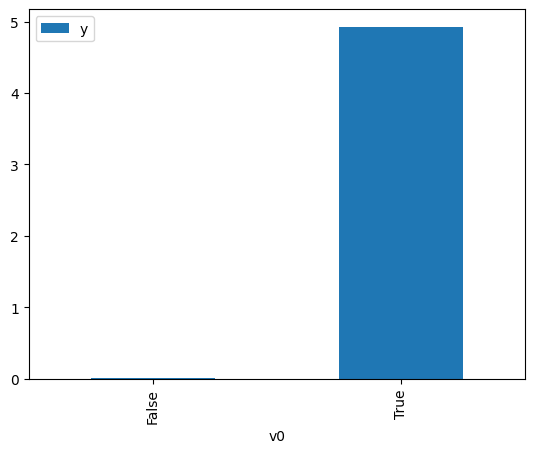

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

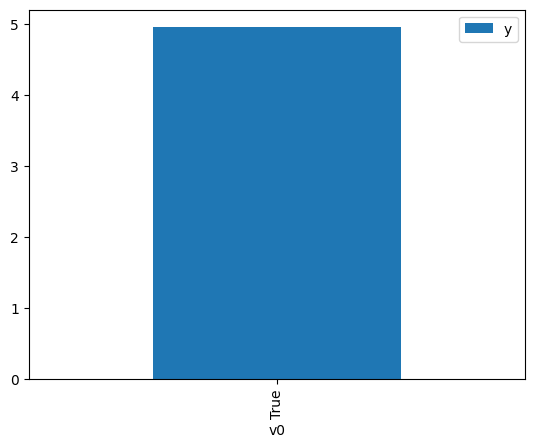

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.392748,False,0.348350,0.485361,2.060321
1,-0.027795,False,1.178441,0.497361,2.010613
2,-1.226358,False,0.496117,0.531530,1.881362
3,-0.549721,False,0.226520,0.512256,1.952150
4,0.406804,False,-0.075801,0.484961,2.062024
...,...,...,...,...,...
995,0.044906,False,0.654673,0.495286,2.019036
996,0.072479,False,-0.786685,0.494499,2.022249
997,0.962766,False,2.677095,0.469126,2.131622
998,-1.106044,False,-0.851667,0.528108,1.893553


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.634226,True,5.974971,0.521522,1.917464
1,1.890716,True,6.289931,0.557149,1.794853
2,-0.247286,True,4.564480,0.496374,2.014609
3,0.040778,True,6.201517,0.504596,1.981782
4,-0.104760,True,6.323085,0.500442,1.998232
...,...,...,...,...,...
995,-2.244410,True,4.694722,0.439665,2.274457
996,0.040778,True,6.201517,0.504596,1.981782
997,-0.754456,True,5.426650,0.481906,2.075094
998,-0.727225,True,5.312729,0.482682,2.071757


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.923
Method:                 Least Squares   F-statistic:                              5971.
Date:                Wed, 22 Mar 2023   Prob (F-statistic):                        0.00
Time:                        16:43:43   Log-Likelihood:                         -1435.8
No. Observations:                1000   AIC:                                      2876.
Df Residuals:                     998   BIC:                                      2885.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3292      0.033      9.990      0.000       0.265       0.394
x2             5.0095      0.046    109.273      0.000       4.920       5.099
==============================================================================
Omnibus:                        2.042   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.360   Jarque-Bera (JB):                1.871
Skew:                          -0.008   Prob(JB):                        0.392
Kurtosis:                       2.789   Cond. No.                         1.41
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""